# 1. Figures in Section 2

## 1.1 Visualize shot charts of Michael Jordan, Stephen Curry, and LeBron James (Figure 1)

── Attaching core tidyverse packages ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ lubridate 1.9.3     ✔ tibble    3.2.1
✔ purrr     1.0.2     ✔ tidyr     1.3.1
── Conflicts ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


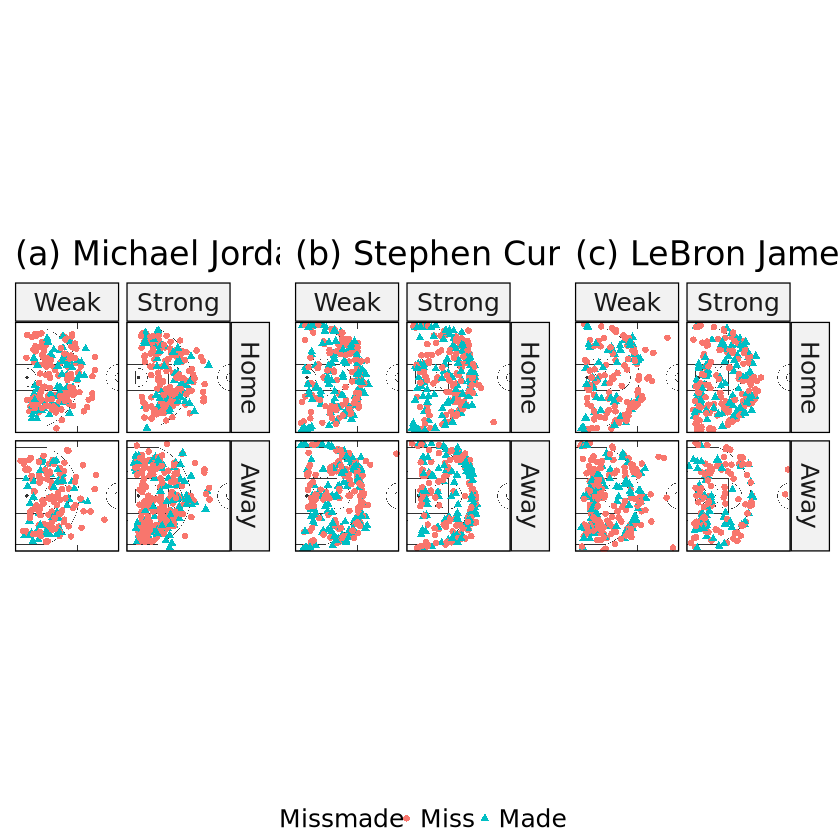

In [1]:
library(ggplot2)
library(tidyverse)
library(ggpubr)
library(ggbasketball)

# Load data
# -------------------------------------

shot_data_ALL = data.frame()
setting_list = c('jordan','curry','james')
for(setting in setting_list){
    if(setting != 'jordan'){
        covar2<-read.table(sprintf("Data/%s/covariates.txt",setting),header=TRUE)
    }else{
        covar2<-read.table(sprintf("Data/%s/covariates_home.txt",setting),header=TRUE)
    }
    
    home = away = rep(0, nrow(covar2))
    home[covar2$home==1] = 1
    away[covar2$home==2] = 1

    level = abs(covar2$level - 2)
    covar = data.frame(game = covar2$game, home, away, level = level)
    if(setting != 'jordan'){
        shot_data = read.table(sprintf("Data/%s/del_%s.txt",setting,setting),header=TRUE)
        shot_data[, 3] = shot_data[, 3]/250 
        shot_data[, 4] = shot_data[, 4]/235 - 39/47
    
    }else{
        shot_data = read.table(sprintf("Data/%s/newdata.txt",setting),header=TRUE)
        bigid = which(shot_data[,6]>28)
        smallid = which(shot_data[, 6]<1)

        shot_data = shot_data[-c(smallid,bigid), ]
        shot_data[, 4] = shot_data[, 4]/300 - 1
        shot_data[, 5] = shot_data[, 5]/235 - 1
    }
     
    # --------------------# --------------------# --------------------
    # Prepar training data
    shot_data = cbind(shot_data, covar[shot_data$Game,c('home','away','level')])
    shot_data = shot_data %>% select(c("Game","Missmade","Xdist","Ydist","Dist","home","away","level"))

    coords_x = 23.5*(shot_data$Ydist+1)
    coords_y = 25*shot_data$Xdist
    shot_data$Xdist = coords_x
    shot_data$Ydist = coords_y
    shot_data$player = setting
    
    shot_data_ALL = rbind(shot_data_ALL, shot_data)
}

cols_to_factor <- c("Game", "Missmade", "home", "away", "level", "player")
shot_data_ALL[cols_to_factor] <- lapply(shot_data_ALL[cols_to_factor], as.factor)
levels(shot_data_ALL$Missmade) = c('Miss','Made')
levels(shot_data_ALL$home) = c('Home','Away')
levels(shot_data_ALL$level) = c('Weak','Strong')

p1 = ggshotchart(shot_data_ALL %>% filter(player == "jordan"),  x = "Xdist", y = "Ydist", result = "Missmade") +
      facet_grid(rows = vars(home), cols=vars(level)) +
      theme(axis.ticks = element_blank(), axis.text = element_blank()) + 
      labs(title = "(a) Michael Jordan") + theme(plot.title = element_text(size=20)) + 
      theme(legend.key.size = unit(0.1, 'cm'),legend.title = element_text(size=15),legend.text = element_text(size=15)) +
                theme(strip.text=element_text(size=15)) + theme(panel.spacing = unit(0.3, 'lines')) 

p2 = ggshotchart(shot_data_ALL %>% filter(player == "curry"),  x = "Xdist", y = "Ydist", result = "Missmade") +
      facet_grid(rows = vars(home), cols=vars(level)) +
      theme(axis.ticks = element_blank(), axis.text = element_blank()) +
      labs(title = "(b) Stephen Curry") + theme(plot.title = element_text(size=20)) + 
      theme(legend.key.size = unit(0.1, 'cm'),legend.title = element_text(size=15),legend.text = element_text(size=15)) +
                theme(strip.text=element_text(size=15)) + theme(panel.spacing = unit(0.3, 'lines')) 

p3 = ggshotchart(shot_data_ALL %>% filter(player == "james"),  x = "Xdist", y = "Ydist", result = "Missmade") +
      facet_grid(rows = vars(home), cols=vars(level)) +
      theme(axis.ticks = element_blank(), axis.text = element_blank()) +
      labs(title = "(c) LeBron James") + theme(plot.title = element_text(size=20)) + 
      theme(legend.key.size = unit(0.1, 'cm'),legend.title = element_text(size=15),legend.text = element_text(size=15)) +
                theme(strip.text=element_text(size=15)) + theme(panel.spacing = unit(0.3, 'lines')) 

ggarrange(p1, p2, p3, nrow = 1, ncol = 3, common.legend = TRUE, legend = "bottom")
ggsave(file = "Figures/Shotchart.pdf", width = 12, height = 5)

# 2. Figures in Section 5

## 2.0 Prepare data

In [ ]:
library(readxl)
library(devtools)
library(dplyr)
library(ggbasketball)
library(combinat)
library(lattice)
library(gridExtra)
library(grid) 
library(patchwork)
library(orthopolynom)
source('Functions/basket_func_same.R')

player_list = c('curry', 'jordan', 'james')
plot_data_intensity <- data.frame()
plot_data_probability <- data.frame()
plot_data_RR <- data.frame()
for(player in player_list)
{
    player_path = sprintf('Data/%s/', player)
    
    load(file=paste0(player_path,  sprintf('%s_homelevel_theta.RData',player)))  # Theta.result: 15000*15*7
    
    # data(shotdata)
    # head(shotdata)
    # dim(shotdata)


    ## Load Model Fitting Results
    ########################################################
    a = 0.25
    d = 2
    b=1.5
    n = GP.eigen.degree(0.8,a=a,b=b,d=d)$n
    L = 15
    
    sgrid=as.matrix(expand.grid(seq(-1,1,length=50),seq(-1,1,length=40)))
    newgrid=matrix(0,nrow=nrow(sgrid),ncol=2)
    newgrid[,1]=300*(sgrid[,1]+1)
    newgrid[,2]=235*(sgrid[,2]+1)
    amat = GP.eigen.funcs(sgrid, n=n, a=a, b=b)
    home_miss_strong = away_miss_strong = home_made_strong = away_made_strong = matrix(0, nrow = nrow(amat), ncol=1)
    home_miss_weak = away_miss_weak = home_made_weak = away_made_weak = matrix(0, nrow = nrow(amat), ncol=1)
    for(i in 1:5000){
      temp.theta = Theta.result[(10000+i),,]
      
      home_miss_strong = home_miss_strong + exp(amat%*%(temp.theta[,1]+temp.theta[,2] + temp.theta[, 4]))
      away_miss_strong = away_miss_strong+exp(amat%*%(temp.theta[,1]+temp.theta[,3]+ temp.theta[, 4]))
      home_made_strong = home_made_strong+exp(amat%*%(temp.theta[,1]+temp.theta[,5]+temp.theta[,7]))
      away_made_strong = away_made_strong+exp(amat%*%(temp.theta[,1]+temp.theta[,6]+temp.theta[,7]))
      home_miss_weak = home_miss_weak+exp(amat%*%(temp.theta[,1]+temp.theta[,2]))
      away_miss_weak = away_miss_weak+exp(amat%*%(temp.theta[,1]+temp.theta[,3]))
      home_made_weak = home_made_weak+exp(amat%*%(temp.theta[,1]+temp.theta[,5]))
      away_made_weak = away_made_weak+exp(amat%*%(temp.theta[,1]+temp.theta[,6]))
    }
    home_miss_strong = home_miss_strong/5000
    home_made_strong = home_made_strong/5000
    away_miss_strong = away_miss_strong/5000
    away_made_strong = away_made_strong/5000
    home_miss_weak = home_miss_weak/5000
    home_made_weak = home_made_weak/5000
    away_miss_weak = away_miss_weak/5000
    away_made_weak = away_made_weak/5000
    
    Miss_home_strong = sqrt(home_miss_strong)
    Miss_away_strong = sqrt(away_miss_strong)
    Made_home_strong = sqrt(home_made_strong)
    Made_away_strong = sqrt(away_made_strong)
    Miss_home_weak = sqrt(home_miss_weak)
    Miss_away_weak = sqrt(away_miss_weak)
    Made_home_weak = sqrt(home_made_weak)
    Made_away_weak = sqrt(away_made_weak)
    my.min=min(Miss_home_strong,Miss_away_strong, Made_home_strong, Made_away_strong,
               Miss_home_weak,Miss_away_weak, Made_home_weak, Made_away_weak)
    my.max=max(Miss_home_strong,Miss_away_strong, Made_home_strong, Made_away_strong,
               Miss_home_weak,Miss_away_weak, Made_home_weak, Made_away_weak)

    ##p(made|s)*p(s)
    home_prob_strong = home_made_strong/sum(home_made_strong + home_miss_strong)
    away_prob_strong = away_made_strong/sum(away_made_strong + away_miss_strong)
    home_prob_weak = home_made_weak/sum(home_made_weak + home_miss_weak)
    away_prob_weak = away_made_weak/sum(away_made_weak + away_miss_weak)
    # 

    ##give strong, risk of home vs away
    strong_risk_home_away = home_prob_strong/away_prob_strong
    weak_risk_home_away = home_prob_weak/away_prob_weak
    ##given home, risk of strong vs weak
    home_risk_strong_weak = home_prob_strong/home_prob_weak
    away_risk_strong_weak = away_prob_strong/away_prob_weak

    # Generating the RR_significant's will take 15~25 minuates, so they have already been stored.
    if(!file.exists(sprintf('Data/%s/RR_significant_%s.RData',player,player))){
        strong_riskcred_home_away = weak_riskcred_home_away = home_riskcred_strong_weak = away_riskcred_strong_weak = NULL

        for(i in 1:5000){
          temp.theta=Theta.result[(10000+i),,]
          thome_miss_strong = exp(amat%*%(temp.theta[,1]+temp.theta[,2] + temp.theta[, 4]))
          taway_miss_strong = exp(amat%*%(temp.theta[,1]+temp.theta[,3]+ temp.theta[, 4]))
          thome_made_strong = exp(amat%*%(temp.theta[,1]+temp.theta[,5]+temp.theta[,7]))
          taway_made_strong = exp(amat%*%(temp.theta[,1]+temp.theta[,6]+temp.theta[,7]))
          thome_miss_weak = exp(amat%*%(temp.theta[,1]+temp.theta[,2]))
          taway_miss_weak = exp(amat%*%(temp.theta[,1]+temp.theta[,3]))
          thome_made_weak = exp(amat%*%(temp.theta[,1]+temp.theta[,5]))
          taway_made_weak = exp(amat%*%(temp.theta[,1]+temp.theta[,6]))

          thome_prob_strong = thome_made_strong/sum(thome_made_strong + thome_miss_strong)
          taway_prob_strong = taway_made_strong/sum(taway_made_strong + taway_miss_strong)
          thome_prob_weak = thome_made_weak/sum(thome_made_weak + thome_miss_weak)
          taway_prob_weak = taway_made_weak/sum(taway_made_weak + taway_miss_weak)

          strong_riskcred_home_away=cbind(strong_riskcred_home_away, thome_prob_strong/taway_prob_strong)
          weak_riskcred_home_away=cbind(weak_riskcred_home_away, thome_prob_weak/taway_prob_weak)
          home_riskcred_strong_weak = cbind(home_riskcred_strong_weak, thome_prob_strong/thome_prob_weak)
          away_riskcred_strong_weak = cbind(away_riskcred_strong_weak, taway_prob_strong/taway_prob_weak)

          if(i%%200==0)
            print(i)
        }


        fquan=function(x){
          return(quantile(x,probs=c(0.05,0.95)))
        }
        strong_credint_home_away=apply(strong_riskcred_home_away,1,fquan)
        weak_credint_home_away=apply(weak_riskcred_home_away,1,fquan)
        home_credint_strong_weak = apply(home_riskcred_strong_weak,1,fquan )
        away_credint_strong_weak = apply(away_riskcred_strong_weak,1,fquan )


        strong_credval_home_away = weak_credval_home_away =
          home_credval_strong_weak = away_credval_strong_weak = rep(0,ncol(strong_credint_home_away))

        for(j in 1:ncol(strong_credint_home_away)){
          if(strong_credint_home_away[1,j]>=1&strong_credint_home_away[2,j]>1) strong_credval_home_away[j]=1
          else if(strong_credint_home_away[1,j]<1&strong_credint_home_away[2,j]<=1) strong_credval_home_away[j]=-1

          if(weak_credint_home_away[1,j]>=1&weak_credint_home_away[2,j]>1) weak_credval_home_away[j]=1
          else if(weak_credint_home_away[1,j]<1&weak_credint_home_away[2,j]<=1) weak_credval_home_away[j]=-1

          if(home_credint_strong_weak[1,j]>=1&home_credint_strong_weak[2,j]>1) home_credval_strong_weak[j]=1
          else if(home_credint_strong_weak[1,j]<1&home_credint_strong_weak[2,j]<=1) home_credval_strong_weak[j]=-1

          if(away_credint_strong_weak[1,j]>=1&away_credint_strong_weak[2,j]>1) away_credval_strong_weak[j]=1
          else if(away_credint_strong_weak[1,j]<1&away_credint_strong_weak[2,j]<=1) away_credval_strong_weak[j]=-1
        }

        save(strong_credval_home_away, weak_credval_home_away, 
          home_credval_strong_weak, away_credval_strong_weak, file = sprintf('Data/%s/RR_significant_%s.RData',player,player))
    }else{
        load(file = sprintf('Data/%s/RR_significant_%s.RData',player,player))
    }

    ## Visualization Data 1
    ########################################################
    # Generate the data for all combinations
    
    for (shot in c('Miss', 'Made')) {
      for (location in c('home', 'away')) {
        for (opposite in c('strong', 'weak')) {
          df <- data.frame(coord1 = 23.5*(sgrid[,2]+1), coord2 = 25*(sgrid[,1]), intensity = get(paste0(shot, '_', location, '_', opposite)))
          df$shot <- shot
          df$location <- location
          df$opposite <- opposite
          df$player <- player
          plot_data_intensity <- rbind(plot_data_intensity, df)
        }
      }
    }
    

    ## Visualization Data 2
    ########################################################

    # Generate the data for all combinations
    for (location in c('home', 'away')) {
    for (opposite in c('strong', 'weak')) {
      df <- data.frame(coord1 = 23.5*(sgrid[,2]+1), coord2 = 25*(sgrid[,1]), probability = get(paste0(location, '_prob_', opposite))) 
      df$location <- location
      df$opposite <- opposite
      df$player <- player
      plot_data_probability <- rbind(plot_data_probability, df)
    }
    }

    ## Visualization Data 3
    ########################################################
    # Generate the data for all combinations
    risk_types = c('strong_risk_home_away','weak_risk_home_away',
                  'home_risk_strong_weak','away_risk_strong_weak')
    risk_names = c('home vs away (strong)','home vs away (weak)',
                  'strong vs weak (home)','strong vs weak (away)')

    for (i_risk in 1:length(risk_types)){
      risk_type = risk_types[i_risk]
      risk_name = risk_names[i_risk]
      df <- data.frame(coord1 = 23.5*(sgrid[,2]+1), coord2 = 25*(sgrid[,1]), RR = get(risk_type)) 
      df$risk_type <- risk_type
      df$risk_name <- risk_name
      df$player <- player
      df$cred_val <- get(gsub("risk", "credval", risk_type))
      plot_data_RR <- rbind(plot_data_RR, df)
    }
}

plot_data_RR$player = factor(plot_data_RR$player, levels = c('curry','james','jordan'))
levels(plot_data_RR$player) = c('Stephen Curry', 'LeBron James','Michael Jordan')

In [23]:
ggshotintensity <- function(intensity, breaks = NULL, palette = NULL,
                            x, y, value_col, color = "black",
                            orientation = "wide",
                            label_name = NULL){
  if (is.null(breaks)) {
    breaks <- unique(round(quantile(intensity[, value_col] + 0.01,
                                    probs = seq(0, 10)/10), 2))
  }
  breaks <- unique(c(c(-1, 0), breaks))
  if (is.null(label_name)) {
    label_name <- "Intensity"
  }

  # intensity[, label_name] <- cut(intensity[, value_col], breaks = breaks)
  court_mapping <- ggpubr::create_aes(list(x = "y", y = "x", group = "group"))
  mapping <-
    ggpubr::create_aes(list(
      x = x
      ,y = y
      ,z = value_col
    ), parse = TRUE)
  # if orientation is tall, swap the mapping
  if (orientation == "tall") {
    temp <- mapping[["x"]]
    mapping[["x"]] <- mapping[["y"]]
    mapping[["y"]] <- temp

    temp <- court_mapping[["x"]]
    court_mapping[["x"]] <- court_mapping[["y"]]
    court_mapping[["y"]] <- temp
  }

  if (is.null(palette)) {
    palette <- colorRampPalette(RColorBrewer::brewer.pal(9, "Blues"))(length(breaks) - 1)
  }

  p <- ggplot() + geom_contour_filled(data = intensity, mapping = mapping,
                                         breaks = breaks, color = color, size = 0.2)  +
    geom_polygon(data = court[court$y <= 47,], mapping = court_mapping) +
    scale_fill_manual(values = palette) +
    coord_fixed() + ggpubr::theme_pubr(border = TRUE) +
    scale_x_continuous(expand = c(0, 0)) +
    scale_y_continuous(expand = c(0, 0)) +
    xlab("") + ylab("") +
    theme(axis.text=element_blank(),
          axis.ticks=element_blank()) +
    labs(fill = label_name)
  p
}

## 2.1 Map of the square root of the estimated intensity (Figure 5)

In [5]:
num_intervals = 15
digit_kept = 2
value_of_interest = plot_data_intensity$intensity
value_quantiles = quantile(value_of_interest, probs = seq(0, num_intervals)/num_intervals)
breaks = round(value_quantiles, digit_kept)
breaks[1] = floor(value_quantiles[1]*10^digit_kept)/10^digit_kept;  breaks[num_intervals+1] = ceiling(value_quantiles[num_intervals+1]*10^digit_kept)/10^digit_kept
breaks = unique(breaks)
plot1 = ggshotintensity(intensity = plot_data_intensity %>% filter(player == 'curry'), x = "coord1", y = "coord2", value_col = "intensity", breaks = breaks) +
      geom_tile() +
      facet_grid(rows = vars(shot), cols=vars(location, opposite)) +
      theme(axis.ticks = element_blank(), axis.text = element_blank()) +
      theme(strip.text=element_text(size=30), panel.spacing = unit(1, 'lines'), legend.position = "none")
plot2 = ggshotintensity(intensity = plot_data_intensity %>% filter(player == 'james'), 
                        x = "coord1", y = "coord2", value_col = "intensity", breaks = breaks, label_name = 'square root intensity') +
      geom_tile() +
      facet_grid(rows = vars(shot), cols=vars(location, opposite)) +
      theme(axis.ticks = element_blank(), axis.text = element_blank()) +
      theme(legend.key.size = unit(2, 'cm'),legend.title = element_text(size=40),legend.text = element_text(size=25), 
            strip.text=element_text(size=40), panel.spacing = unit(1, 'lines'), legend.position = "right") 
plot3 = ggshotintensity(intensity = plot_data_intensity %>% filter(player == 'jordan'), x = "coord1", y = "coord2", value_col = "intensity", breaks = breaks) +
      geom_tile() +
      facet_grid(rows = vars(shot), cols=vars(location, opposite)) +
      theme(axis.ticks = element_blank(), axis.text = element_blank()) +
      theme(strip.text=element_text(size=30), panel.spacing = unit(1, 'lines'), legend.position = "none") 

plot1 = plot1 + labs(title = '(a) Stephen Curry') + theme(plot.title = element_text(size = 30, hjust = 0.5, vjust = -1.5, face = "bold"), )
plot2 = plot2 + labs(title = '(b) LeBron James') + theme(plot.title = element_text(size = 30, hjust = 0.5, vjust = -1.5, face = "bold"))
plot3 = plot3 + labs(title = '(c) Michael Jordan') + theme(plot.title = element_text(size = 30, hjust = 0.5, vjust = -1.5, face = "bold"))


# Combine the plots
combined_plot <- (plot1 / plot2 / plot3) +
  plot_layout(heights = unit(c(1, 1, 1), "null"))

# Save the combined plot to a PDF file
pdf("Figures/shot_intensity.pdf", width = 20, height = 30)

combined_plot
dev.off()

pdf 
  2

## 2.2 Map of the estimated probability density function (Figure 6)

In [6]:
num_intervals = 10
digit_kept = 5
value_of_interest = plot_data_probability$probability
value_quantiles = quantile(value_of_interest, probs = seq(0, num_intervals)/num_intervals)
breaks = round(value_quantiles, digit_kept)
breaks[1] = floor(value_quantiles[1]*10^digit_kept)/10^digit_kept;  breaks[num_intervals+1] = ceiling(value_quantiles[num_intervals+1]*10^digit_kept)/10^digit_kept
breaks = unique(breaks)

plot1 = ggshotintensity(intensity = plot_data_probability %>% filter(player == 'curry'), x = "coord1", y = "coord2", value_col = "probability", breaks = breaks) +
      geom_tile() +
      facet_grid(rows = vars(location), cols=vars(opposite)) +
      theme(axis.ticks = element_blank(), axis.text = element_blank()) +
      theme(strip.text=element_text(size=30), panel.spacing = unit(1, 'lines'), legend.position = "none")
plot2 = ggshotintensity(intensity = plot_data_probability %>% filter(player == 'james'), x = "coord1", y = "coord2", value_col = "probability", breaks = breaks) +
      geom_tile() +
      facet_grid(rows = vars(location), cols=vars(opposite)) +
      theme(axis.ticks = element_blank(), axis.text = element_blank()) +
      theme(strip.text=element_text(size=30), panel.spacing = unit(1, 'lines'), legend.position = "none") 
plot3 = ggshotintensity(intensity = plot_data_probability %>% filter(player == 'jordan'), x = "coord1", y = "coord2", value_col = "probability", breaks = breaks, label_name = 'probability density') +
      geom_tile() +
      facet_grid(rows = vars(location), cols=vars(opposite)) +
      theme(axis.ticks = element_blank(), axis.text = element_blank()) +
      theme(strip.text=element_text(size=30), panel.spacing = unit(1, 'lines'), legend.position = "none") + 
      theme(legend.key.size = unit(1.5, 'cm'),legend.title = element_text(size=30),legend.text = element_text(size=25), 
            legend.position = "right") 

# Combine the plots
combined_plot <- (plot1 | plot2 | plot3) 

# Save the combined plot to a PDF file
pdf("Figures/shot_prob.pdf", width = 30, height = 13)

# combined_plot
grid.newpage()
pushViewport(viewport(layout = grid.layout(1, 4, widths = unit(c(6, 6, 6, 1), "null"))))

# Draw the combined plot
print(combined_plot, vp = viewport(layout.pos.row = 1, layout.pos.col = 1:3))

# Add titles to the right of each plot, with reduced space
grid.text("(a) Stephen Curry", x = unit(1/8, "npc"), y = unit(0.9, "npc"), gp = gpar(fontsize = 40, fontface = "bold"), rot = 0)
grid.text("(b) LeBron James", x = unit(3.2/8, "npc"), y = unit(0.9, "npc"), gp = gpar(fontsize = 40, fontface = "bold"), rot = 0)
grid.text("(c) Michael Jordan", x = unit(5.35/8, "npc"), y = unit(0.9, "npc"), gp = gpar(fontsize = 40, fontface = "bold"), rot = 0)
dev.off()

pdf 
  2

## 2.3 Map of the estimated home vs away relative risk for Stephen Curry and LeBron James (Figure 7)

In [7]:
ggshotintensity <- function(intensity, breaks = NULL, palette = NULL,
                            x, y, value_col, color = "black",
                            orientation = "wide",
                            label_name = NULL){
  if (is.null(breaks)) {
    breaks <- unique(round(quantile(intensity[, value_col] + 0.01,
                                    probs = seq(0, 10)/10), 2))
  }
  breaks <- unique(c(c(-1, 0), breaks))
  if (is.null(label_name)) {
    label_name <- "Intensity"
  }

  # intensity[, label_name] <- cut(intensity[, value_col], breaks = breaks)
  court_mapping <- ggpubr::create_aes(list(x = "y", y = "x", group = "group"))
  mapping <-
    ggpubr::create_aes(list(
      x = x
      ,y = y
      ,z = value_col
    ), parse = TRUE)
  # if orientation is tall, swap the mapping
  if (orientation == "tall") {
    temp <- mapping[["x"]]
    mapping[["x"]] <- mapping[["y"]]
    mapping[["y"]] <- temp

    temp <- court_mapping[["x"]]
    court_mapping[["x"]] <- court_mapping[["y"]]
    court_mapping[["y"]] <- temp
  }

  if (is.null(palette)) {
    palette <- colorRampPalette(RColorBrewer::brewer.pal(9, "Blues"))(length(breaks) - 1)
  }

  p <- ggplot() + geom_contour_filled(data = intensity, mapping = mapping,
                                         breaks = breaks, color = color, size = 0.2)  +
    geom_polygon(data = court[court$y <= 47,], mapping = court_mapping) +
    scale_fill_manual(values = palette) +
    coord_fixed() + ggpubr::theme_pubr(border = TRUE) +
    scale_x_continuous(expand = c(0, 0)) +
    scale_y_continuous(expand = c(0, 0)) +
    xlab("") + ylab("") +
    theme(
          axis.text=element_blank(),
          axis.ticks=element_blank()) +
    labs(fill = label_name) +
    geom_contour(data = intensity, mapping = mapping, breaks = 1, color = "orange", size = 2)
  p
}

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


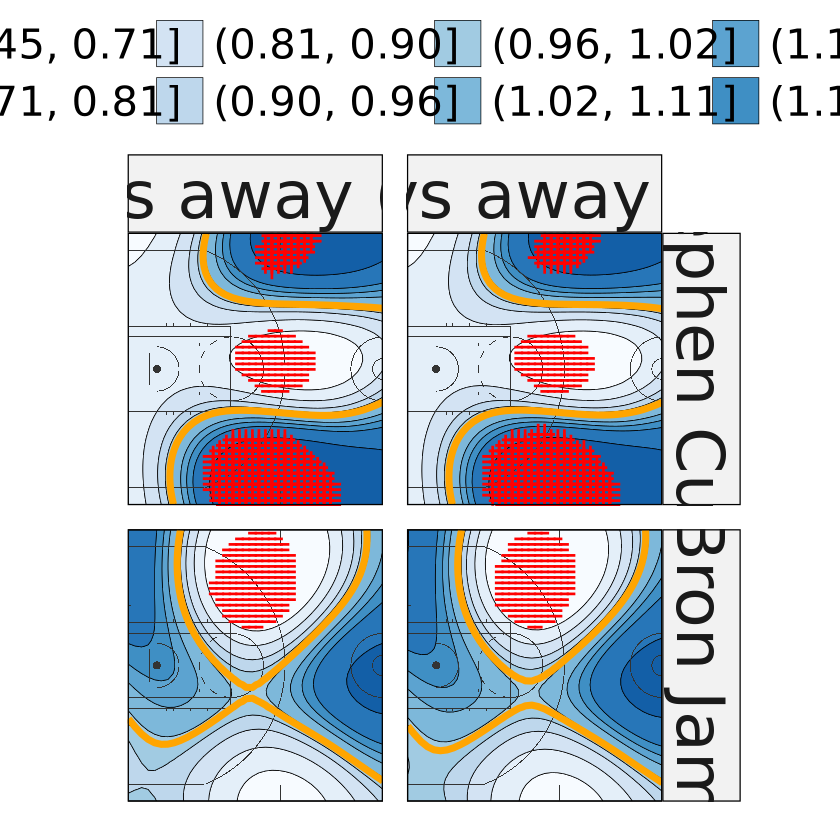

In [8]:
num_intervals = 10
digit_kept = 2
value_of_interest = plot_data_RR$RR
value_quantiles = quantile(value_of_interest, probs = seq(0, num_intervals)/num_intervals)
breaks = round(value_quantiles, digit_kept)
breaks[1] = floor(value_quantiles[1]*10^digit_kept)/10^digit_kept;  breaks[num_intervals+1] = ceiling(value_quantiles[num_intervals+1]*10^digit_kept)/10^digit_kept
breaks = unique(breaks)

breaks[1] = min(plot_data_RR$RR); breaks[length(breaks)] = max(plot_data_RR$RR)
ggshotintensity(intensity = plot_data_RR %>% 
                filter(player %in% c('Stephen Curry','LeBron James') & 
                      risk_name %in% c('home vs away (strong)','home vs away (weak)')), 
                x = "coord1", y = "coord2", 
                value_col = "RR", breaks = breaks, label_name = 'relative risk') +
                geom_text( data =  plot_data_RR %>% 
                                    filter(player %in% c('Stephen Curry','LeBron James') & 
                                          risk_name %in% c('home vs away (strong)','home vs away (weak)')),
                      aes(x = coord1, y = coord2, label = ifelse(cred_val == 1, "+", ifelse(cred_val == -1, "-", ""))),
                          vjust = 0.5, hjust = 0.5, color = "red",size = 7) +
  geom_tile() +
  facet_grid(rows = vars(player), cols=vars(risk_name)) +
  theme(axis.ticks = element_blank(), axis.text = element_blank()) +
  theme(legend.key.size = unit(1, 'cm'),legend.title = element_text(size=40),legend.text = element_text(size=25)) +
            theme(strip.text=element_text(size=40)) + theme(panel.spacing = unit(1, 'lines')) 

# Save the plot
ggsave(filename = 'Figures/shot_RR_Fig3.pdf', width = 15, height = 15)

## 2.4 Map of the estimated relative for Michael Jordan (Figure 8)

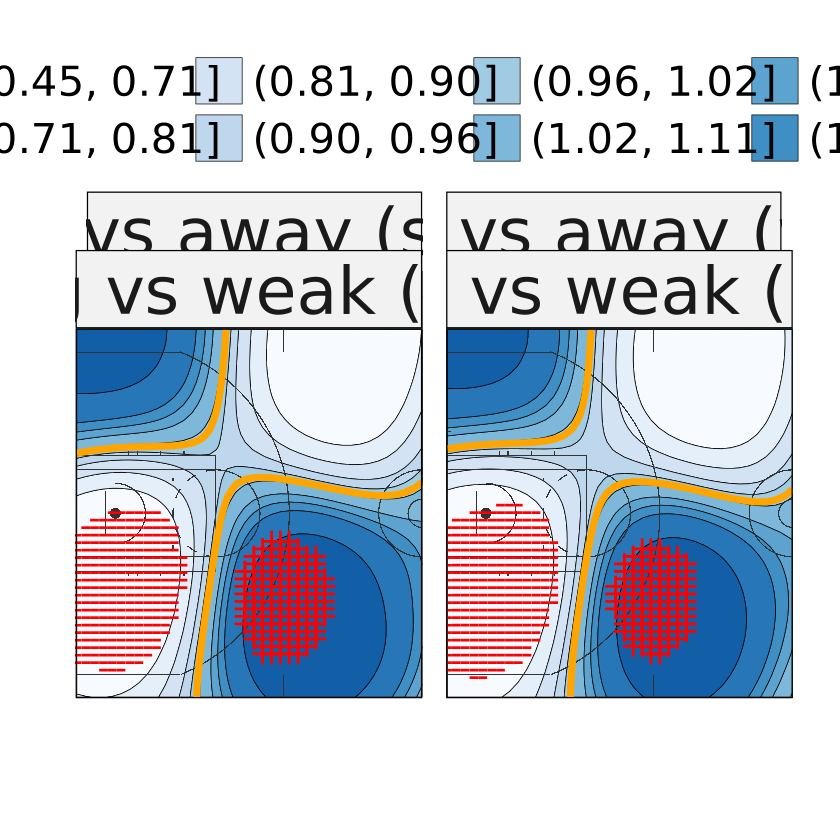

In [9]:
plot1 = ggshotintensity(intensity = plot_data_RR %>% 
                filter(player %in% c('Michael Jordan') & 
                      risk_name %in% c('home vs away (strong)','home vs away (weak)')), 
                x = "coord1", y = "coord2", 
                value_col = "RR", breaks = breaks, label_name = 'relative risk') +
                geom_text( data =  plot_data_RR %>% 
                                    filter(player %in% c('Michael Jordan') & 
                                          risk_name %in% c('home vs away (strong)','home vs away (weak)')),
                      aes(x = coord1, y = coord2, label = ifelse(cred_val == 1, "+", ifelse(cred_val == -1, "-", ""))),
                          vjust = 0.5, hjust = 0.5, color = "red",size = 7) +
  geom_tile() +
  facet_grid(cols = vars(risk_name)) +
  theme(axis.ticks = element_blank(), axis.text = element_blank()) +
  theme(legend.key.size = unit(1, 'cm'),legend.title = element_text(size=40),legend.text = element_text(size=25)) +
            theme(strip.text=element_text(size=40)) + theme(panel.spacing = unit(1, 'lines')) +
  theme(plot.margin = unit(c(1, 1, -5, 1), "cm"))

plot2 = ggshotintensity(intensity = plot_data_RR %>% 
                filter(player %in% c('Michael Jordan') & 
                      !(risk_name %in% c('home vs away (strong)','home vs away (weak)'))), 
                x = "coord1", y = "coord2", 
                value_col = "RR", breaks = breaks, label_name = 'relative risk') +
                geom_text( data =  plot_data_RR %>% 
                                    filter(player %in% c('Michael Jordan') & 
                                          !(risk_name %in% c('home vs away (strong)','home vs away (weak)'))),
                      aes(x = coord1, y = coord2, label = ifelse(cred_val == 1, "+", ifelse(cred_val == -1, "-", ""))),
                          vjust = 0.5, hjust = 0.5, color = "red",size = 7) +
  geom_tile() +
  facet_grid(cols = vars(risk_name)) +
  theme(axis.ticks = element_blank(), axis.text = element_blank()) +
  theme(legend.position = 'none') +
            theme(strip.text=element_text(size=40)) + theme(panel.spacing = unit(1, 'lines')) +
  theme(plot.margin = unit(c(-5, 1, 1, 1), "cm"))

plot_all = grid.arrange(plot1, plot2, ncol=1)
# Save the plot
ggsave(plot_all, filename = 'Figures/shot_RR_Fig4.pdf', width = 15, height = 22)

## 2.5 Map of the estimated relative risk for Stephen Curry and LeBron James (Figure S.1)

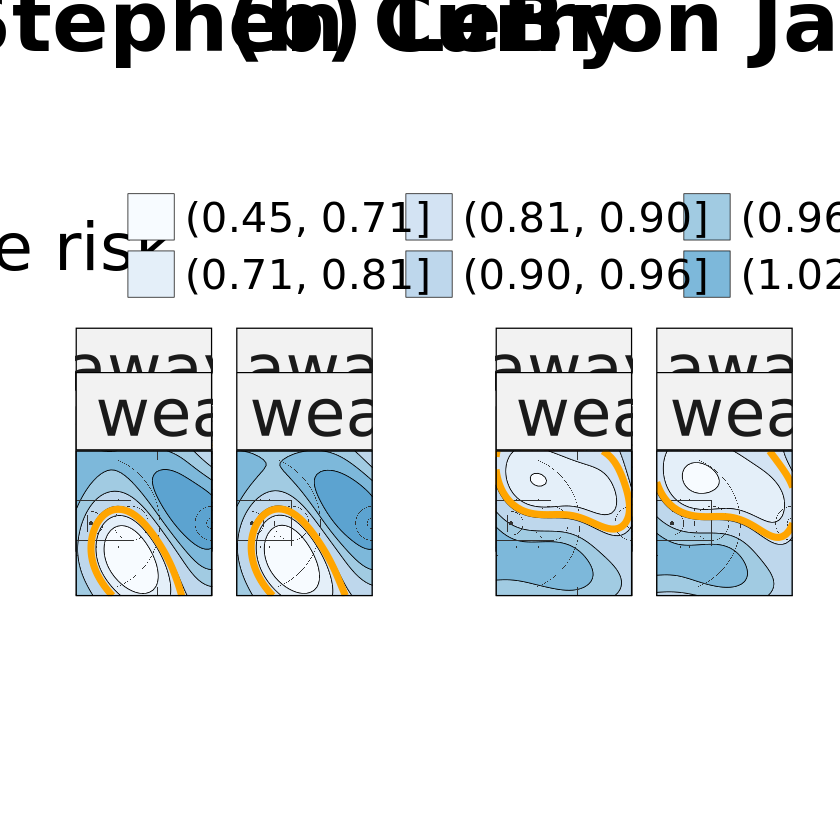

In [10]:
plot1 = ggshotintensity(intensity = plot_data_RR %>% 
                filter(player %in% c('Stephen Curry') & 
                      risk_name %in% c('home vs away (strong)','home vs away (weak)')), 
                x = "coord1", y = "coord2", 
                value_col = "RR", breaks = breaks, label_name = 'relative risk') +
                geom_text( data =  plot_data_RR %>% 
                                    filter(player %in% c('Stephen Curry') & 
                                          risk_name %in% c('home vs away (strong)','home vs away (weak)')),
                      aes(x = coord1, y = coord2, label = ifelse(cred_val == 1, "+", ifelse(cred_val == -1, "-", ""))),
                          vjust = 0.5, hjust = 0.5, color = "red",size = 7) +
  geom_tile() +
  facet_grid(cols = vars(risk_name)) +
  theme(axis.ticks = element_blank(), axis.text = element_blank()) +
  theme(legend.key.size = unit(1, 'cm'),legend.title = element_text(size=40),legend.text = element_text(size=25)) +
            theme(strip.text=element_text(size=40)) + theme(panel.spacing = unit(1, 'lines')) +
  theme(plot.margin = unit(c(1, 1, -5, 1), "cm"))

plot2 = ggshotintensity(intensity = plot_data_RR %>% 
                filter(player %in% c('Stephen Curry') & 
                      !(risk_name %in% c('home vs away (strong)','home vs away (weak)'))), 
                x = "coord1", y = "coord2", 
                value_col = "RR", breaks = breaks, label_name = 'relative risk') +
                geom_text( data =  plot_data_RR %>% 
                                    filter(player %in% c('Stephen Curry') & 
                                          !(risk_name %in% c('home vs away (strong)','home vs away (weak)'))),
                      aes(x = coord1, y = coord2, label = ifelse(cred_val == 1, "+", ifelse(cred_val == -1, "-", ""))),
                          vjust = 0.5, hjust = 0.5, color = "red",size = 7) +
  geom_tile() +
  facet_grid(cols = vars(risk_name)) +
  theme(axis.ticks = element_blank(), axis.text = element_blank()) +
  theme(legend.position = 'none') +
            theme(strip.text=element_text(size=40)) + theme(panel.spacing = unit(1, 'lines')) +
  theme(plot.margin = unit(c(-5, 1, 1, 1), "cm"))


plot3 = ggshotintensity(intensity = plot_data_RR %>% 
                filter(player %in% c('LeBron James') & 
                      risk_name %in% c('home vs away (strong)','home vs away (weak)')), 
                x = "coord1", y = "coord2", 
                value_col = "RR", breaks = breaks, label_name = 'relative risk') +
                geom_text( data =  plot_data_RR %>% 
                                    filter(player %in% c('LeBron James') & 
                                          risk_name %in% c('home vs away (strong)','home vs away (weak)')),
                      aes(x = coord1, y = coord2, label = ifelse(cred_val == 1, "+", ifelse(cred_val == -1, "-", ""))),
                          vjust = 0.5, hjust = 0.5, color = "red",size = 7) +
  geom_tile() +
  facet_grid(cols = vars(risk_name)) +
  theme(axis.ticks = element_blank(), axis.text = element_blank()) +
  theme(legend.key.size = unit(1, 'cm'),legend.title = element_text(size=40),legend.text = element_text(size=25)) +
            theme(strip.text=element_text(size=40)) + theme(panel.spacing = unit(1, 'lines')) +
  theme(plot.margin = unit(c(1, 1, -5, 1), "cm"))

plot4 = ggshotintensity(intensity = plot_data_RR %>% 
                filter(player %in% c('LeBron James') & 
                      !(risk_name %in% c('home vs away (strong)','home vs away (weak)'))), 
                x = "coord1", y = "coord2", 
                value_col = "RR", breaks = breaks, label_name = 'relative risk') +
                geom_text( data =  plot_data_RR %>% 
                                    filter(player %in% c('LeBron James') & 
                                          !(risk_name %in% c('home vs away (strong)','home vs away (weak)'))),
                      aes(x = coord1, y = coord2, label = ifelse(cred_val == 1, "+", ifelse(cred_val == -1, "-", ""))),
                          vjust = 0.5, hjust = 0.5, color = "red",size = 7) +
  geom_tile() +
  facet_grid(cols = vars(risk_name)) +
  theme(axis.ticks = element_blank(), axis.text = element_blank()) +
  theme(legend.position = 'none') +
            theme(strip.text=element_text(size=40)) + theme(panel.spacing = unit(1, 'lines')) +
  theme(plot.margin = unit(c(-5, 1, 1, 1), "cm"))

# Create titles
title1 <- textGrob("(a) Stephen Curry", gp=gpar(fontsize=50, fontface="bold"), just = "center")
title2 <- textGrob("(b) LeBron James", gp=gpar(fontsize=50, fontface="bold"), just = "center")

# Combine titles and plots
col1 <- arrangeGrob(title1, plot1, plot2, ncol = 1, heights = c(0.1, 1, 1))
col2 <- arrangeGrob(title2, plot3, plot4, ncol = 1, heights = c(0.1, 1, 1))

# Arrange the columns
plot_all <- grid.arrange(col1, col2, ncol = 2)

# Save the plot
ggsave(plot_all, filename = 'Figures/shot_RR_Fig5.pdf', width = 30, height = 23)